## Visualising the ORA data as Emapplots

Note you should be running at least python 3.8

In [3]:
from scircm import plot_cluster_ORA
import os

base_dir = '../data/'
data_dir = f'{base_dir}sircle/F3_regulatory_clustering/ORA_results/'
output_dir = f'{base_dir}sircle/F3_regulatory_clustering/ORA_results/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
test_title = 'all_patients_ccRCC'



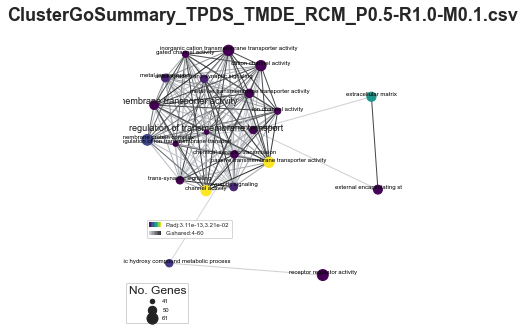

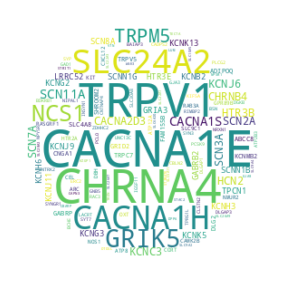

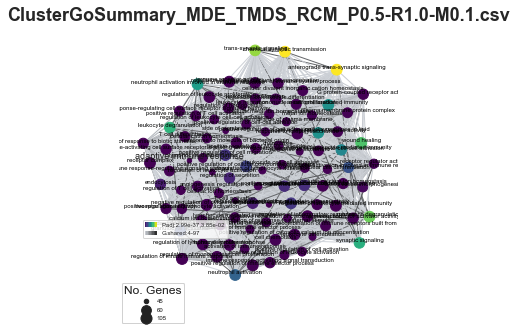

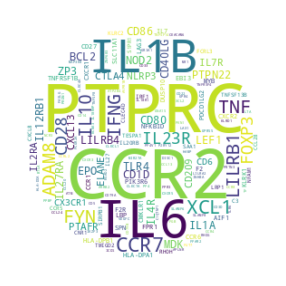

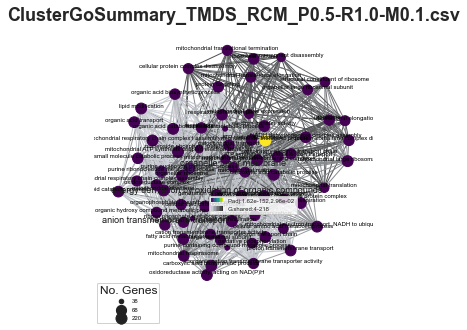

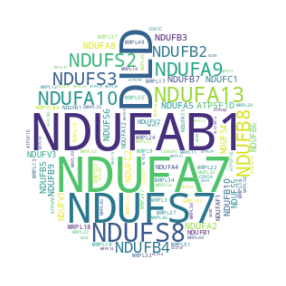

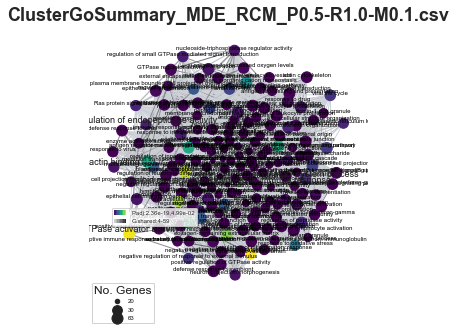

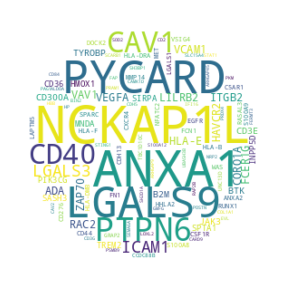

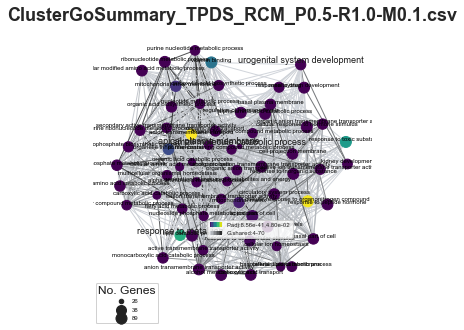

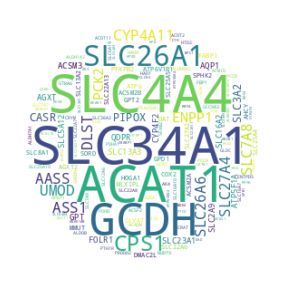

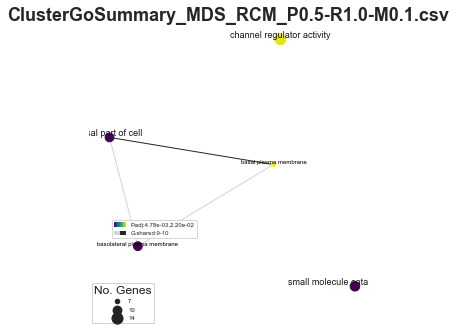

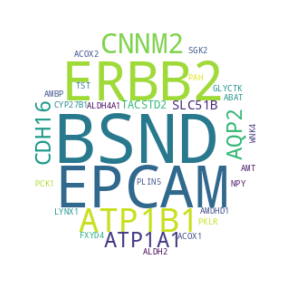

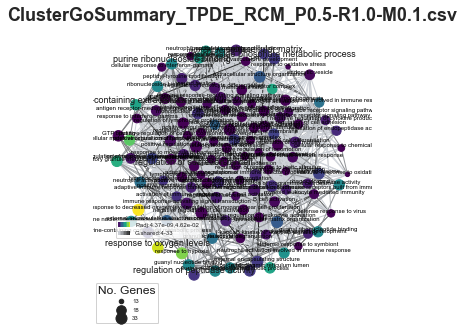

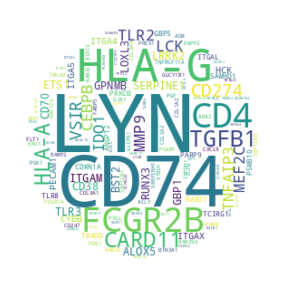

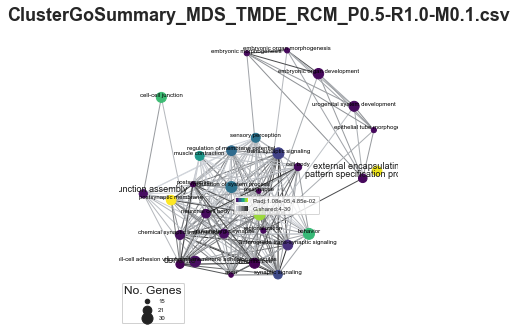

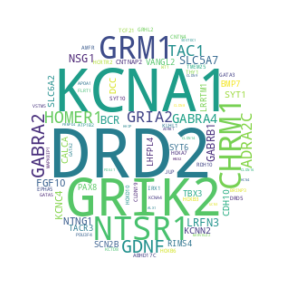

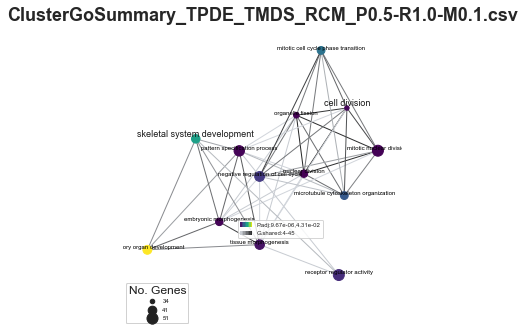

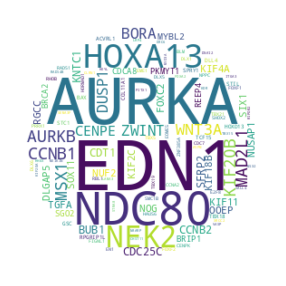

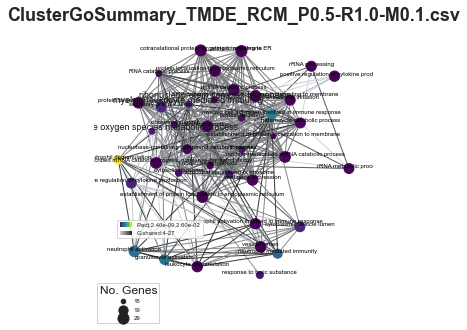

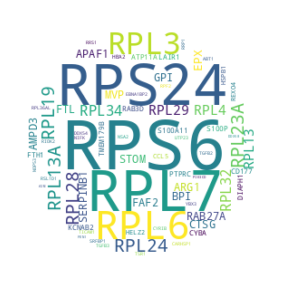

In [55]:

files = os.listdir(data_dir)
cluster_files = [c for c in files if 'ClusterGoSummary' in c]

for c in cluster_files:
    if '.svg' not in c:
        plot_cluster_ORA(f'{data_dir}{c}', figsize=(5,5), save_fig=False, title=c)

## Looking at overlap between the individual data types

Here we are interested in how many GO terms overlapped between the protein, RNA and DNA methylation. 

We look at this by testing the overlap and also looking at what came up individually.

In [56]:

def plot_cluster_ORA(filename, gene_ratio='GeneRatio', count_column='Count', padj='p.adjust', overlap_column='geneID',
                     id_column='ID', label_column='Description', gene_ratio_min=0.05, padj_max=0.05, title='',
                     label_font_size=9, figsize=(3, 3), axis_font_size=6, min_count=20, max_count=200, 
                     min_overlap=4,
                     save_fig=True):
    """

    Parameters
    ----------
    filename
    gene_ratio
    count_column
    padj
    overlap_column
    id_column
    label_column
    gene_ratio_min
    padj_max
    title
    label_font_size
    figsize
    axis_font_size
    min_count
    max_count
    min_overlap
    save_fig

    Returns
    -------

    """
    df = pd.read_csv(f'{filename}')
    # Convert gene ratio to a number
    gr = df[gene_ratio].values
    gene_ratios = []
    for g in gr:
        g = g.split('/')
        g0 = float(g[0])
        g1 = float(g[1])
        gene_ratios.append(g0 / g1)
    df[gene_ratio] = gene_ratios
    df = df[df[gene_ratio] > gene_ratio_min]
    df = df[df[padj] < padj_max]
    if len(df) > 1:
        eplot = Emapplot(df, size_column=count_column, color_column=padj, id_column=id_column,
                         label_column=label_column, overlap_column=overlap_column, overlap_sep='/', title=title,
                         config={'figsize': figsize, 'label_font_size': label_font_size,
                                 'axis_font_size': axis_font_size})
        eplot.build_graph(min_overlap=min_overlap)
        plt.title(title, fontsize=18, fontweight='bold')
        plt.gca().set_clip_on = False

        if save_fig:
            plt.savefig(f'{filename.replace(".csv", "")}_Network.svg', bbox_inches='tight', transparent=True)
        plt.show()

        x, y = np.ogrid[:300, :300]
        plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
        plt.rcParams['figure.figsize'] = figsize
        mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
        mask = 255 * mask.astype(int)
        wordfeqs = defaultdict(int)
        for g in df[overlap_column].values:
            for w in g.split('/'):
                w = w.replace(' ', '.')
                wordfeqs[w] += 1
        total_words = len(wordfeqs)
        for w in wordfeqs:
            wordfeqs[w] = wordfeqs[w] / total_words
        # Compute the frequency of each word (since there are duplicates sometimes...)
        wordcloud = WordCloud(background_color="white", mask=mask, repeat=False).generate_from_frequencies(wordfeqs)
        wordcloud_svg = wordcloud.to_svg(embed_font=True)
        if save_fig:
            f = open(f'{filename.replace(".csv", "")}_WordCloud.svg', "w+")
            f.write(wordcloud_svg)
            f.close()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [51]:
test_title

'all_patients_ccRCC'

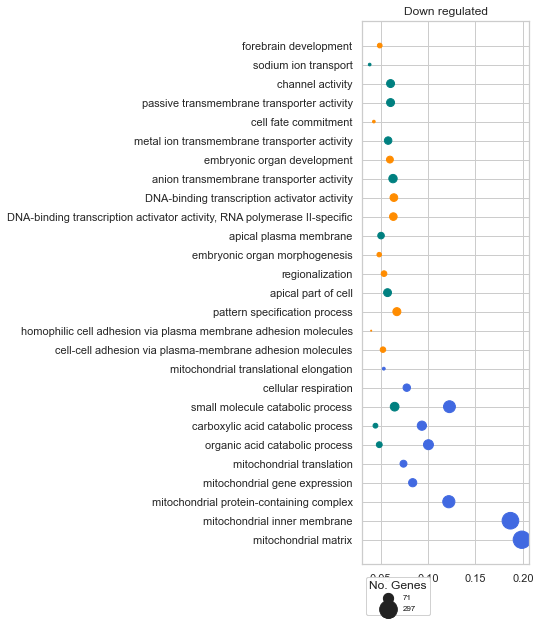

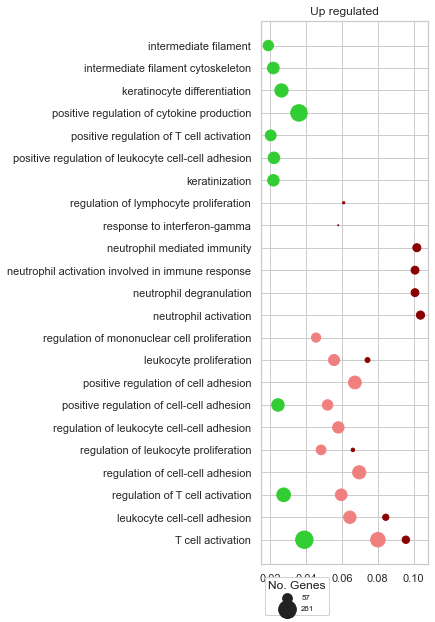

In [54]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,10)

sns.set_theme(style="whitegrid")
cmaps = {'Down regulated': {'CpG': 'darkorange', 'Protein': 'royalblue', 'RNA': 'teal'},
        'Up regulated': {'CpG': 'limegreen', 'Protein': 'darkred', 'RNA': 'lightcoral'},
        }
for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    rna_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in rna_df['GeneRatio'].values]
    rna_df['Data'] = 'RNA'
    rna_df.sort_values('p.adjust', inplace=True)

    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    protein_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in protein_df['GeneRatio'].values]
    protein_df['Data'] = 'Protein'
    protein_df.sort_values('p.adjust', inplace=True)

    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    cpg_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in cpg_df['GeneRatio'].values]
    cpg_df['Data'] = 'CpG'
    cpg_df.sort_values('p.adjust', inplace=True)

    # Concat all together
    num = 10
    rna_df = pd.concat([rna_df.head(num), cpg_df.head(num), protein_df.head(num)])
    rna_df.sort_values('p.adjust', inplace=True)

    max_c = max(rna_df['Count'].values)
    min_c = min(rna_df['Count'].values)
    size = [int(1 + ((int(c) - min_c)/(max_c - min_c))*300) for c in rna_df['Count'].values]


    norm = mpl.colors.Normalize(vmin=np.min(rna_df['p.adjust'].values), vmax=np.max(rna_df['p.adjust'].values))
    cmap = cm.RdBu
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    c_map = cmaps[c]
    colours = [c_map.get(v) for v in rna_df['Data'].values]
    plt.scatter(rna_df['GeneRatio'].values, rna_df['Description'].values, s=size, c=colours)#c=m.to_rgba(rna_df['p.adjust'].values))
    plt.title(c)
    
#     # Add legends
#     cmap_labels = [f'G.shared:{min(overlapping_numbers)}-{max(overlapping_numbers)}']
#     # create proxy artists as handles:
#     cmaps = [edge_cmap]
#     cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
#     handler_map = dict(zip(cmap_handles,
#                            [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
#     legend2 = plt.legend(handles=cmap_handles,
#                labels=cmap_labels,
#                handler_map=handler_map,
#                fontsize=8, loc='upper right')

#     plt.gca().add_artist(legend2)

    gmin = plt.scatter([], [], s=10 + int(300*(min_c/(max_c - min_c))), marker='o', color='#222')
    #gmid = plt.scatter([], [], s=int(10 + 300*(((max_c - min_c)/2)/max_c)), marker='o', color='#222')
    gmax = plt.scatter([], [], s=10 + int(300*(1)), marker='o', color='#222')
    legend = plt.legend((gmin, gmax),
                        (str(min_c), str(max_c)),
                        scatterpoints=1,
                        loc='lower left',
                        ncol=1,
                        fontsize=8, bbox_to_anchor=(0, -0.1))
    
    legend.set_title("No. Genes")
    plt.gca().add_artist(legend)
    plt.savefig(f'{output_dir}DotPlot_GO_{c}.svg')
    plt.show()
#sns.stripplot(data=rna_df.head(30), y='Description', x='GeneRatio', size=size) #, color='p.adjust', size='Count')

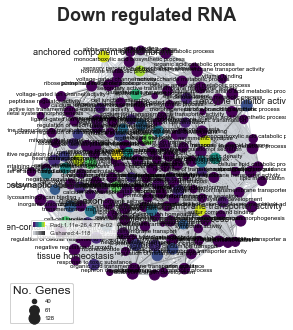

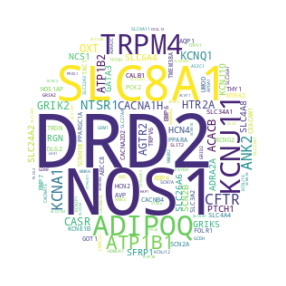

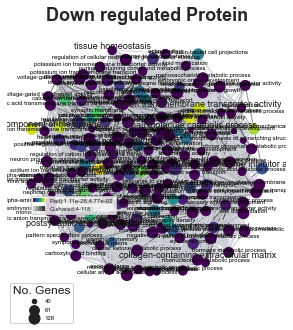

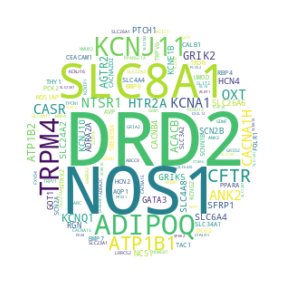

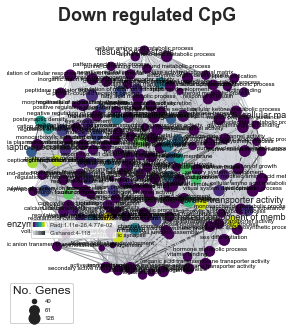

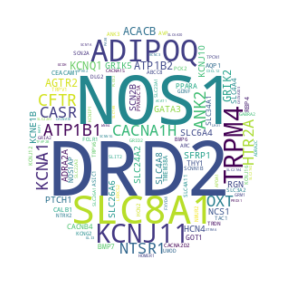

--------------------------------------------------------------------------------
                    RNA sig:	799	Protein sig:	732	CpG:	688	                     
--------------------------------------------------------------------------------


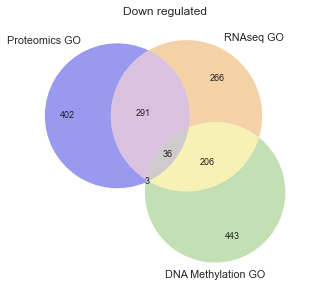

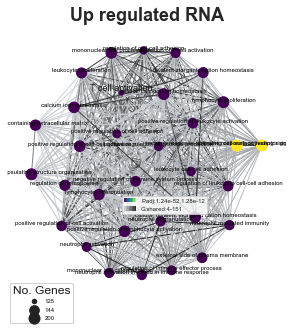

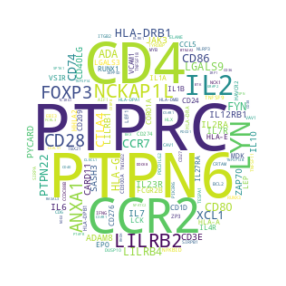

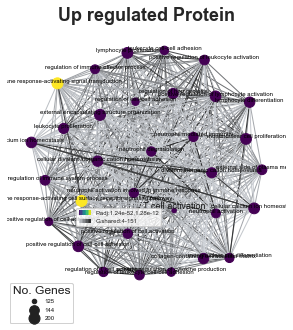

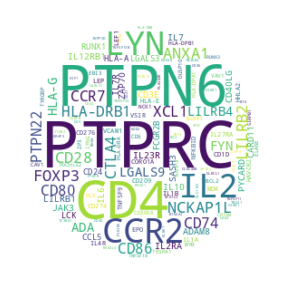

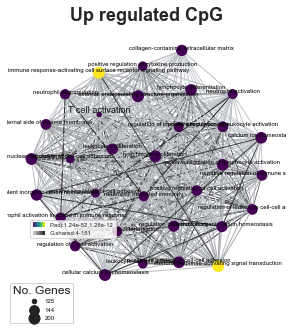

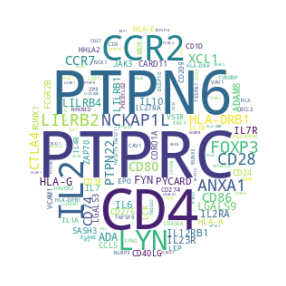

--------------------------------------------------------------------------------
                   RNA sig:	1444	Protein sig:	1313	CpG:	648	                    
--------------------------------------------------------------------------------


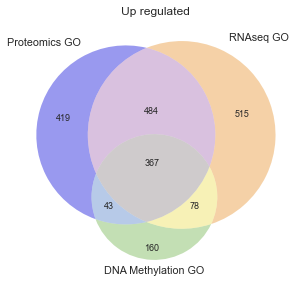

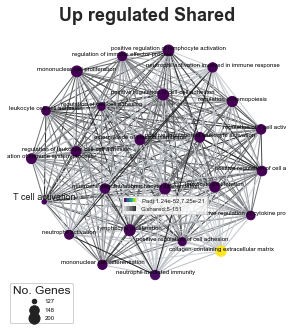

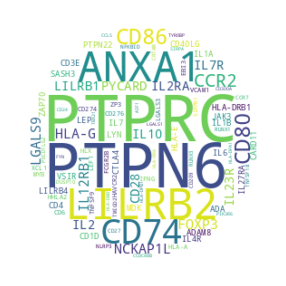

In [9]:
from scircm import plot_cluster_ORA
import os
import pandas as pd
from sciutil import SciUtil
from matplotlib import rcParams
from matplotlib_venn import venn3
from sciutil import SciUtil
import matplotlib.pyplot as plt
import seaborn as sns
u = SciUtil()

u = SciUtil()
base_dir = '../data/'
data_dir = f'../figures/'
output_dir = f'../figures/'
test_title = 'all_patients_ccRCC'

files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Down regulated': ['RNA_Negative_LogFC-1_pvalue0.05.csv',
                                  'Protein_Negative_LogFC-0.5_pvalue0.05.csv',
                                  'CpG_Positive_LogFC0.1_pvalue0.05.csv'
                                 ],
               'Up regulated': ['RNA_Positive_LogFC1_pvalue0.05.csv',
                                'Protein_Positive_LogFC0.5_pvalue0.05.csv',
                                 'CpG_Negative_LogFC-0.1_pvalue0.05.csv'
                                 ]
              }

for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    plot_cluster_ORA(f'{data_dir}{test_title}_{comparisons[c][0]}', title=f'{c} RNA', figsize=(5,5), save_fig=True, gene_ratio_min=gr)

    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    plot_cluster_ORA(f'{data_dir}{test_title}_{comparisons[c][0]}', title=f'{c} Protein', figsize=(5,5), save_fig=True, gene_ratio_min=gr)

    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    plot_cluster_ORA(f'{data_dir}{test_title}_{comparisons[c][0]}', title=f'{c} CpG', figsize=(5,5), save_fig=True, gene_ratio_min=gr)

    # Look at significant terms
    rna_df = rna_df[rna_df['p.adjust'] < 0.05]
    protein_df = protein_df[protein_df['p.adjust'] < 0.05]
    cpg_df = cpg_df[cpg_df['p.adjust'] < 0.05]
    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    
    venn3([set(protein_df.ID.values), set(rna_df.ID.values), set(cpg_df.ID.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.title(c)
    plt.savefig(f'{data_dir}{c}_venn.svg')
    plt.show()
    # Look at what is the same (shared between all) and what is unique to each one
    shared = rna_df[rna_df.ID.isin(list(set(protein_df.ID.values)&set(cpg_df.ID.values)))]
    # Do a emap plot
    shared.to_csv(f'{data_dir}{c}_shared.csv')
    gr = 0.05
    plot_cluster_ORA(f'{data_dir}{c}_shared.csv', title=f'{c} Shared', figsize=(5,5), save_fig=True, gene_ratio_min=gr)
    
#     # Plot RNA only
#     rna_df_only = rna_df[~rna_df.ID.isin(list(protein_df.ID.values) + list(cpg_df.ID.values))]
#     protein_df_only = protein_df[~protein_df.ID.isin(list(rna_df.ID.values) + list(cpg_df.ID.values))]
#     cpg_df_only = cpg_df[~cpg_df.ID.isin(list(rna_df.ID.values) + list(protein_df.ID.values))]

#     rna_df_only.to_csv(f'{data_dir}{c}_rna.csv')
#     plot_cluster_ORA(f'{data_dir}{c}_rna.csv', title=f'{c} RNA', figsize=(5,5), save_fig=True, gene_ratio_min=gr)

#     protein_df_only.to_csv(f'{data_dir}{c}_protein.csv')
#     plot_cluster_ORA(f'{data_dir}{c}_protein.csv', title=f'{c} Protein', figsize=(5,5), save_fig=True, gene_ratio_min=gr)
    
#     cpg_df_only.to_csv(f'{data_dir}{c}_cpg.csv')
#     plot_cluster_ORA(f'{data_dir}{c}_cpg.csv', title=f'{c} CpG', figsize=(5,5), save_fig=True, gene_ratio_min=gr)


# Pring out the number of DEGs for S1, S4, S4 vs S1

In [125]:
data_dir = f'{base_dir}sircle/F3_regulatory_clustering/ORA_results/'
input_dir = f'{base_dir}sircle/F2_DE_output_TvN/'

for d in os.listdir(input_dir):
    if 'Stage I_' in d and 'Stage IV' in d:
        df = pd.read_csv(f'{input_dir}{d}')
        padj = [c for c in df.columns if 'padj' in c][0]
    #     cutoff = 1.0
    #     v = 'logFC_rna'
    #     if 'prot' in d:
    #         cutoff = 0.5
    #     elif 'cpg' in d:
    #         cutoff = 1.0
        print(d, len(df[df[padj] < 0.05]))

prot_DE_Stage IV vs Stage I_sircle.csv 118
rna_DE_Stage IV vs Stage I_sircle.csv 12209
cpg_DE_Stage IV vs Stage I_sircle.csv 24229


--------------------------------------------------------------------------------
                    RNA sig:	688	Protein sig:	605	CpG:	2098	                    
--------------------------------------------------------------------------------


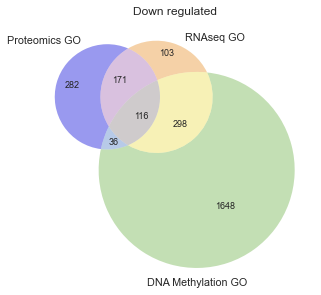

--------------------------------------------------------------------------------
                   RNA sig:	1407	Protein sig:	1259	CpG:	1181	                   
--------------------------------------------------------------------------------


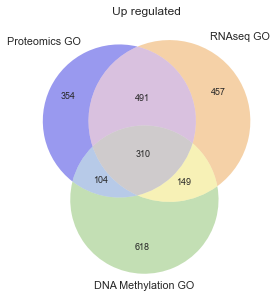

In [24]:

test_title = 'Stage_IV'

files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Down regulated': ['RNAseq_Negative_LogFC-1_pvalue0.05.csv',
                                  'Protein_Negative_LogFC-0.5_pvalue0.05.csv',
                                  'Methylation_Positive_LogFC0.1_pvalue0.05.csv'
                                 ],
               'Up regulated': ['RNAseq_Positive_LogFC1_pvalue0.05.csv',
                                'Protein_Positive_LogFC0.5_pvalue0.05.csv',
                                 'Methylation_Negative_LogFC-0.1_pvalue0.05.csv'
                                 ]
              }
for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    # Look at significant terms
    rna_df = rna_df[rna_df['p.adjust'] < 0.05]
    protein_df = protein_df[protein_df['p.adjust'] < 0.05]
    cpg_df = cpg_df[cpg_df['p.adjust'] < 0.05]
    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    
    venn3([set(protein_df.ID.values), set(rna_df.ID.values), set(cpg_df.ID.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.title(c)
    plt.show()


In [15]:
test_title = 'Stage_I_'
data_dir = '../figures/'
files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Down regulated': ['RNAseq_Negative_LogFC-1_pvalue0.05.csv',
                                  'Protein_Negative_LogFC-0.5_pvalue0.05.csv',
                                  'Methylation_Positive_LogFC0.1_pvalue0.05.csv'
                                 ],
               'Up regulated': ['RNAseq_Positive_LogFC1_pvalue0.05.csv',
                                'Protein_Positive_LogFC0.5_pvalue0.05.csv',
                                 'Methylation_Negative_LogFC-0.1_pvalue0.05.csv'
                                 ]
              }
for c in comparisons:
    combined_df = pd.DataFrame()
    for v in comparisons[c]:
        label = v
        s1_df = pd.read_csv(f'{data_dir}Stage_I_{v}')
        s4_df = pd.read_csv(f'{data_dir}Stage_IV_{v}')
        # Combine the DFs to save for mor easy viewing
        s1_df['Data'] = [label]*len(s1_df)
        s4_df['Data'] = [label]*len(s4_df)
        combined_df = combined_df.append(s1_df)
        combined_df = combined_df.append(s4_df)

        # Look at significant terms
        s1_df = s1_df[s1_df['p.adjust'] < 0.05]
        s4_df = s4_df[s4_df['p.adjust'] < 0.05]
        u.dp([c, v.split('_')[0], 'S4 sig:', len(s4_df), 'S1 sig:', len(s1_df), 'Overlap:', len(set(s1_df.ID.values) & set((s4_df.ID.values))), len(set(s1_df.ID.values) & set((s4_df.ID.values)))/max(len(s4_df), len(s1_df))])
#         plt.rcParams['svg.fonttype'] = 'none'
#         plt.title(c)
#         plt.show()
    combined_df.to_csv(f'../data/sircle/F8_simple_integration/{c}_StageI-TvN_StageIV-TvN.csv', index=False)

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s1_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s4_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s1_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined

--------------------------------------------------------------------------------
 Down regulated	RNAseq	S4 sig:	688	S1 sig:	759	Overlap:	516	0.6798418972332015	 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Down regulated	Protein	S4 sig:	605	S1 sig:	752	Overlap:	547	0.7273936170212766	 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Down regulated	Methylation	S4 sig:	2098	S1 sig:	227	Overlap:	211	0.1005719733079123	
--------------------------------------------------------------------------------


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s1_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s4_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(s1_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1309966208.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined

--------------------------------------------------------------------------------
Up regulated	RNAseq	S4 sig:	1407	S1 sig:	1624	Overlap:	1250	0.7697044334975369	 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Up regulated	Protein	S4 sig:	1259	S1 sig:	1321	Overlap:	1068	0.8084784254352763	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Up regulated	Methylation	S4 sig:	1181	S1 sig:	19	Overlap:	15	0.012701100762066046	
--------------------------------------------------------------------------------


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  c

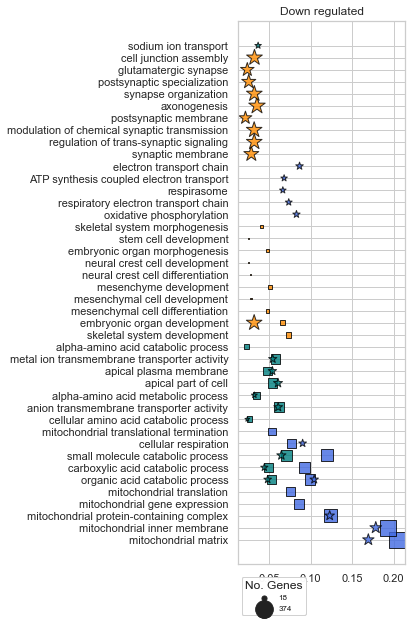

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/1974884147.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  c

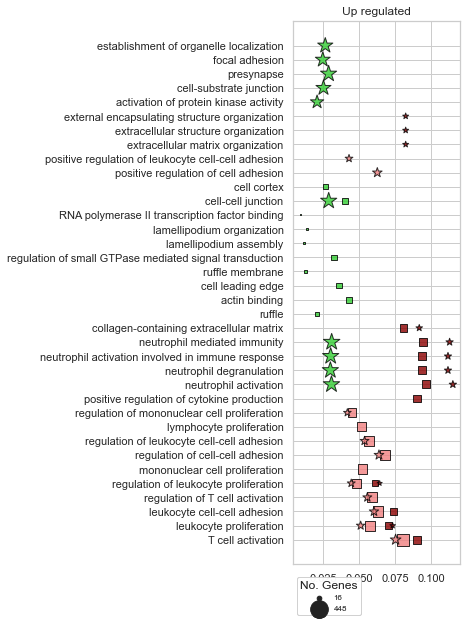

In [18]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,10)

sns.set_theme(style="whitegrid")
#cmaps = {'Down regulated': {'CpG': 'darkorange', 'Protein': 'royalblue', 'RNA': 'teal'},
#         'Up regulated': {'CpG': 'limegreen', 'Protein': 'darkred', 'RNA': 'lightcoral'},
#         }
cmaps = {'Down regulated': {'CpG S1': 'darkorange', 'Protein S1': 'royalblue', 'RNA S1': 'teal', 
                           'CpG S4': 'darkorange', 'Protein S4': 'royalblue', 'RNA S4': 'teal'},
        'Up regulated': {'CpG S1': 'limegreen', 'Protein S1': 'darkred', 'RNA S1': 'lightcoral', 
                           'CpG S4': 'limegreen', 'Protein S4': 'darkred', 'RNA S4': 'lightcoral'},
        }

# cmaps = {'Down regulated': {'CpG S1': 'chocolate', 'Protein S1': 'royalblue', 'RNA S1': 'teal', 
#                            'CpG S4': 'orange', 'Protein S4': 'navy', 'RNA S4': 'turquoise'},
#         'Up regulated': {'CpG S1': 'green', 'Protein S1': 'red', 'RNA S1': 'orange', 
#                            'CpG S4': 'limegreen', 'Protein S4': 'darkred', 'RNA S4': 'lightcoral'},
#         }
num = 10
sizes = {'Down regulated': {'min': 18, 'max': 374},
        'Up regulated': {'min': 16, 'max': 448}}
for c in comparisons:
    combined_df = pd.DataFrame()
    rna_df = pd.read_csv(f'{data_dir}Stage_I_{comparisons[c][0]}')
    rna_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in rna_df['GeneRatio'].values]
    rna_df['Data'] = 'RNA S1'
    rna_df.sort_values('p.adjust', inplace=True)

    protein_df = pd.read_csv(f'{data_dir}Stage_I_{comparisons[c][1]}')
    protein_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in protein_df['GeneRatio'].values]
    protein_df['Data'] = 'Protein S1'
    protein_df.sort_values('p.adjust', inplace=True)

    cpg_df = pd.read_csv(f'{data_dir}Stage_I_{comparisons[c][2]}')
    cpg_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in cpg_df['GeneRatio'].values]
    cpg_df['Data'] = 'CpG S1'
    cpg_df.sort_values('p.adjust', inplace=True)
    combined_df = combined_df.append(rna_df)
    combined_df = combined_df.append(cpg_df)
    combined_df = combined_df.append(protein_df)
    
    rna_df = pd.concat([rna_df.head(num), cpg_df.head(num), protein_df.head(num)])
    rna_df.sort_values('p.adjust', inplace=True)

    max_c = sizes[c]['max'] ##max(rna_df['Count'].values)
    min_c = sizes[c]['min']  #min(rna_df['Count'].values)
    size = [int(1 + ((int(c) - min_c)/(max_c - min_c))*300) for c in rna_df['Count'].values]
    

    norm = mpl.colors.Normalize(vmin=np.min(rna_df['p.adjust'].values), vmax=np.max(rna_df['p.adjust'].values))
    cmap = cm.RdBu
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    c_map = cmaps[c]
    colours = [c_map.get(v) for v in rna_df['Data'].values]
    plt.scatter(rna_df['GeneRatio'].values, rna_df['Description'].values, s=size, c=colours, marker=',', 
                edgecolors='black', alpha=0.8)#c=m.to_rgba(rna_df['p.adjust'].values))

        
    rna_df = pd.read_csv(f'{data_dir}Stage_IV_{comparisons[c][0]}')
    rna_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in rna_df['GeneRatio'].values]
    rna_df['Data'] = 'RNA S4'
    rna_df.sort_values('p.adjust', inplace=True)

    protein_df = pd.read_csv(f'{data_dir}Stage_IV_{comparisons[c][1]}')
    protein_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in protein_df['GeneRatio'].values]
    protein_df['Data'] = 'Protein S4'
    protein_df.sort_values('p.adjust', inplace=True)

    cpg_df = pd.read_csv(f'{data_dir}Stage_IV_{comparisons[c][2]}')
    cpg_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in cpg_df['GeneRatio'].values]
    cpg_df['Data'] = 'CpG S4'
    cpg_df.sort_values('p.adjust', inplace=True)
    combined_df = combined_df.append(rna_df)
    combined_df = combined_df.append(cpg_df)
    combined_df = combined_df.append(protein_df)
    # Concat all together
    num = 10
    rna_df = pd.concat([rna_df.head(num), cpg_df.head(num), protein_df.head(num)])
    rna_df.sort_values('p.adjust', inplace=True)

    max_c = sizes[c]['max'] ##max(rna_df['Count'].values)
    min_c = sizes[c]['min']  #min(rna_df['Count'].values)
    size = [int(1 + ((int(c) - min_c)/(max_c - min_c))*300) for c in rna_df['Count'].values]


    norm = mpl.colors.Normalize(vmin=np.min(rna_df['p.adjust'].values), vmax=np.max(rna_df['p.adjust'].values))
    cmap = cm.RdBu
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    c_map = cmaps[c]
    colours = [c_map.get(v) for v in rna_df['Data'].values]
    plt.scatter(rna_df['GeneRatio'].values, rna_df['Description'].values, s=size, c=colours, edgecolors='black', marker='*',  alpha=0.8)#c=m.to_rgba(rna_df['p.adjust'].values))
    plt.title(c)
    
#     # Add legends
#     cmap_labels = [f'G.shared:{min(overlapping_numbers)}-{max(overlapping_numbers)}']
#     # create proxy artists as handles:
#     cmaps = [edge_cmap]
#     cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
#     handler_map = dict(zip(cmap_handles,
#                            [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
#     legend2 = plt.legend(handles=cmap_handles,
#                labels=cmap_labels,
#                handler_map=handler_map,
#                fontsize=8, loc='upper right')

#     plt.gca().add_artist(legend2)
    combined_df.to_csv(f'../data/sircle/F8_simple_integration/{c}_StageIV-StageI-TvN.csv', index=False)

    gmin = plt.scatter([], [], s=10 + int(300*(min_c/(max_c - min_c))), marker='o', color='#222')
    #gmid = plt.scatter([], [], s=int(10 + 300*(((max_c - min_c)/2)/max_c)), marker='o', color='#222')
    gmax = plt.scatter([], [], s=10 + int(300*(1)), marker='o', color='#222')
    legend = plt.legend((gmin, gmax),
                        (str(min_c), str(max_c)),
                        scatterpoints=1,
                        loc='lower left',
                        ncol=1,
                        fontsize=8, bbox_to_anchor=(0, -0.1))
    
    legend.set_title("No. Genes")
    plt.gca().add_artist(legend)
    plt.savefig(f'{output_dir}DotPlot_GO_{c}_S1-S4.svg')
    plt.show()
#sns.stripplot(data=rna_df.head(30), y='Description', x='GeneRatio', size=size) #, color='p.adjust', size='Count')

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)


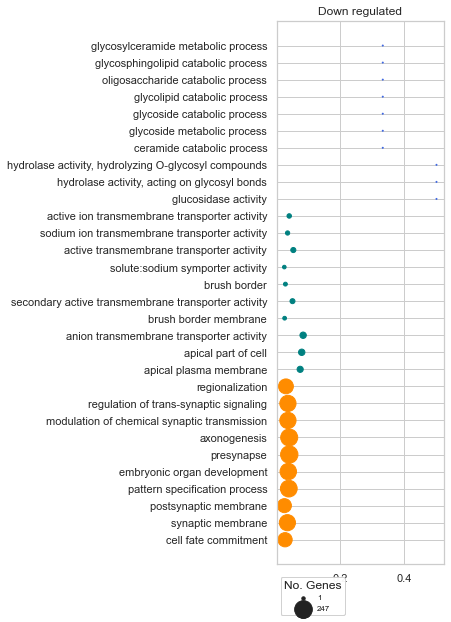

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3731675.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)


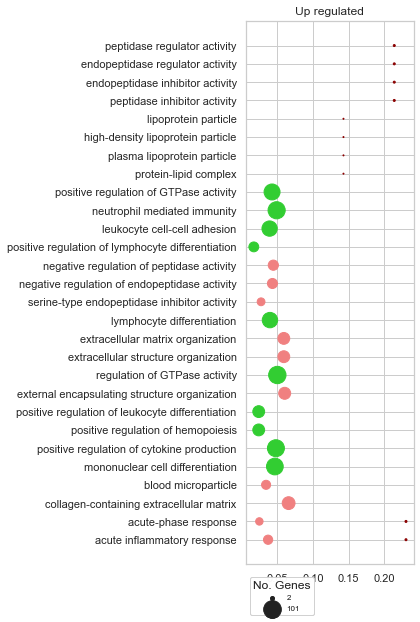

In [19]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,10)

sns.set_theme(style="whitegrid")
cmaps = {'Down regulated': {'CpG': 'darkorange', 'Protein': 'royalblue', 'RNA': 'teal'},
        'Up regulated': {'CpG': 'limegreen', 'Protein': 'darkred', 'RNA': 'lightcoral'},
        }
test_title = 'Stage_IV_vs_Stage_I'
data_dir = '../figures/'

comparisons = {'Down regulated': ['RNAseq_Negative_LogFC-1_pvalue0.05.csv',
                                  'Protein_Negative_LogFC-0.5_pvalue0.05.csv',
                                  'Methylation_Positive_LogFC0.1_pvalue0.05.csv'
                                 ],
               'Up regulated': ['RNAseq_Positive_LogFC1_pvalue0.05.csv',
                                'Protein_Positive_LogFC0.5_pvalue0.05.csv',
                                 'Methylation_Negative_LogFC-0.1_pvalue0.05.csv'
                                 ]
              }

for c in comparisons:
    combined_df = pd.DataFrame()
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    rna_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in rna_df['GeneRatio'].values]
    rna_df['Data'] = 'RNA'
    rna_df = rna_df[rna_df['p.adjust'] < 0.05]

    rna_df.sort_values('p.adjust', inplace=True)

    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    protein_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in protein_df['GeneRatio'].values]
    protein_df['Data'] = 'Protein'
    protein_df = protein_df[protein_df['p.adjust'] < 0.05]
    protein_df.sort_values('p.adjust', inplace=True)

    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    cpg_df['GeneRatio'] = [int(g.split('/')[0])/int(g.split('/')[1]) for g in cpg_df['GeneRatio'].values]
    cpg_df['Data'] = 'CpG'
    cpg_df = cpg_df[cpg_df['p.adjust'] < 0.05]

    cpg_df.sort_values('p.adjust', inplace=True)
    combined_df = combined_df.append(rna_df)
    combined_df = combined_df.append(cpg_df)
    combined_df = combined_df.append(protein_df)
    # Concat all together
    num = 10
    rna_df = pd.concat([rna_df.head(num), cpg_df.head(num), protein_df.head(num)])
    rna_df.sort_values('p.adjust', inplace=True)

    max_c = max(rna_df['Count'].values)
    min_c = min(rna_df['Count'].values)
    size = [int(1 + ((int(c) - min_c)/(max_c - min_c))*300) for c in rna_df['Count'].values]


    norm = mpl.colors.Normalize(vmin=np.min(rna_df['p.adjust'].values), vmax=np.max(rna_df['p.adjust'].values))
    cmap = cm.RdBu
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    c_map = cmaps[c]
    colours = [c_map.get(v) for v in rna_df['Data'].values]
    plt.scatter(rna_df['GeneRatio'].values, rna_df['Description'].values, s=size, c=colours)#c=m.to_rgba(rna_df['p.adjust'].values))
    plt.title(c)
    combined_df.to_csv(f'../data/sircle/F8_simple_integration/{c}_StageIV-StageI-Tumour.csv', index=False)

    gmin = plt.scatter([], [], s=10 + int(300*(min_c/(max_c - min_c))), marker='o', color='#222')
    #gmid = plt.scatter([], [], s=int(10 + 300*(((max_c - min_c)/2)/max_c)), marker='o', color='#222')
    gmax = plt.scatter([], [], s=10 + int(300*(1)), marker='o', color='#222')
    legend = plt.legend((gmin, gmax),
                        (str(min_c), str(max_c)),
                        scatterpoints=1,
                        loc='lower left',
                        ncol=1,
                        fontsize=8, bbox_to_anchor=(0, -0.1))
    
    legend.set_title("No. Genes")
    plt.gca().add_artist(legend)
    plt.savefig(f'{output_dir}DotPlot_GO_{c}.svg')
    plt.show()
#sns.stripplot(data=rna_df.head(30), y='Description', x='GeneRatio', size=size) #, color='p.adjust', size='Count')

## Look at the metabolic pathways

--------------------------------------------------------------------------------
                    RNA sig:	144	Protein sig:	46	CpG:	1726	                     
--------------------------------------------------------------------------------


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)


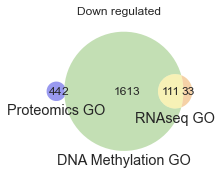

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3494167829.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)


--------------------------------------------------------------------------------
                     RNA sig:	302	Protein sig:	65	CpG:	427	                     
--------------------------------------------------------------------------------


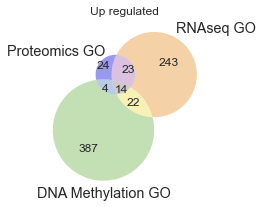

In [23]:
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scircm import plot_cluster_ORA
import os
import pandas as pd
from sciutil import SciUtil
from matplotlib import rcParams
from matplotlib_venn import venn3
from sciutil import SciUtil
import matplotlib.pyplot as plt
import seaborn as sns
from sciutil import SciUtil
u = SciUtil()
plt.rcParams["figure.figsize"] = (3,10)

test_title = 'Stage_IV_vs_Stage_I'
p_cuttoff = 0.25
data_dir = '../figures/'
files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Down regulated': ['RNAseq_Negative_LogFC-1_pvalue0.05.csv',
                                  'Protein_Negative_LogFC-0.5_pvalue0.05.csv',
                                  'Methylation_Positive_LogFC0.1_pvalue0.05.csv'
                                 ],
               'Up regulated': ['RNAseq_Positive_LogFC1_pvalue0.05.csv',
                                'Protein_Positive_LogFC0.5_pvalue0.05.csv',
                                 'Methylation_Negative_LogFC-0.1_pvalue0.05.csv'
                                 ]
              }
for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    # Look at significant terms
    rna_df = rna_df[rna_df['p.adjust'] < p_cuttoff]
    protein_df = protein_df[protein_df['p.adjust'] < p_cuttoff]
    cpg_df = cpg_df[cpg_df['p.adjust'] < p_cuttoff]

    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    
    venn3([set(protein_df.ID.values), set(rna_df.ID.values), set(cpg_df.ID.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.title(c)
    #plt.savefig(f'{output_dir}Venn_GO_{test_title}_{c}.svg')
    plt.show()


In [8]:
rna_df

ONTOLOGY          ID                                       Description  \
0         BP  GO:0002526                       acute inflammatory response   
1         BP  GO:0006953                              acute-phase response   
2         BP  GO:0045229     external encapsulating structure organization   
3         BP  GO:0030198                 extracellular matrix organization   
4         BP  GO:0043062              extracellular structure organization   
..       ...         ...                                               ...   
297       MF  GO:0008017                               microtubule binding   
298       MF  GO:0008083                            growth factor activity   
299       MF  GO:0008514  organic anion transmembrane transporter activity   
300       MF  GO:0120015                          sterol transfer activity   
301       MF  GO:0005544            calcium-dependent phospholipid binding   

    GeneRatio    BgRatio        pvalue      p.adjust        qvalue  \
0      30/814  107/18862  8.992403e-17  4.321749e-13  3.764504e-13   
1      20/814   46/18862  7.753710e-16  1.863217e-12  1.622974e-12   
2      49/814  396/18862  3.149318e-11  5.045207e-08  4.394680e-08   
3      48/814  393/18862  7.939952e-11  8.340701e-08  7.265253e-08   
4      48/814  394/18862  8.677383e-11  8.340701e-08  7.265253e-08   
..        ...        ...           ...           ...           ...   
297    23/815  269/18337  2.131021e-03  4.053895e-02  3.516054e-02   
298    16/815  162/18337  2.356993e-03  4.266155e-02  3.700153e-02   
299    17/815  177/18337  2.357416e-03  4.266155e-02  3.700153e-02   
300     5/815   22/18337  2.399060e-03  4.266155e-02  3.700153e-02   
301     8/815   54/18337  2.496967e-03  4.345784e-02  3.769217e-02   

                                                geneID  Count  
0    ITIH4/OSM/HAMP/IL1A/FN1/F3/TREM1/APOL2/LBP/EPO...     30  
1    ITIH4/HAMP/IL1A/FN1/APOL2/LBP/EPO/APCS/SAA2/IL...     20  
2    CD44/IBSP/LAMC2/CPB2/TLL2/APLP1/HAS1/SERPINE1/...     49  
3    CD44/IBSP/LAMC2/CPB2/TLL2/APLP1/HAS1/SERPINE1/...     48  
4    CD44/IBSP/LAMC2/CPB2/TLL2/APLP1/HAS1/SERPINE1/...     48  
..                                                 ...    ...  
297  NAV3/KIF2A/GTSE1/TPX2/BIRC5/KIF4A/KIF20A/CENPF...     23  
298  HGF/OSM/FGF9/MDK/EREG/LIF/IL6/FGF5/INHBE/FGF18...     16  
299  SLC38A5/SLCO4A1/SLC17A9/SLC52A3/SLC7A5/SLC1A6/...     17  
300                       GRAMD1B/APOB/PLTP/APOA4/MTTP      5  
301     SYT7/SYT13/SYT8/CPNE7/CPNE4/SYT3/ANXA8L1/ANXA8      8  

[302 rows x 10 columns]

--------------------------------------------------------------------------------
                    RNA sig:	144	Protein sig:	46	CpG:	1726	                     
--------------------------------------------------------------------------------


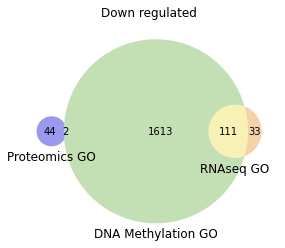

--------------------------------------------------------------------------------
                     RNA sig:	302	Protein sig:	65	CpG:	427	                     
--------------------------------------------------------------------------------


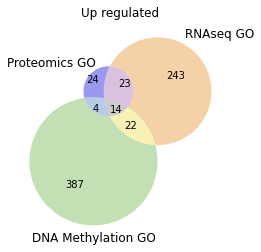

In [7]:
p_cuttoff = 0.05
for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    # Look at significant terms
    rna_df = rna_df[rna_df['p.adjust'] < p_cuttoff]
    protein_df = protein_df[protein_df['p.adjust'] < p_cuttoff]
    cpg_df = cpg_df[cpg_df['p.adjust'] < p_cuttoff]
    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    
    venn3([set(protein_df.ID.values), set(rna_df.ID.values), set(cpg_df.ID.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.title(c)
    #plt.savefig(f'{output_dir}Venn_GO_{test_title}_{c}.svg')
    plt.show()



In [92]:
pd.read_csv('../figures/Stage_IV_vs_Stage_I_RNAseq_GSEA_MetabolicPathways.csv')

pathway      pval      padj        ES  \
0            Alanine and Aspartate Metabolism  0.153687  0.363995 -0.318521   
1       Amino and Nucleotide Sugar Metabolism  0.020025  0.128732  0.555470   
2             Arginine and Proline Metabolism  0.059882  0.239963  0.444313   
3                     beta-Alanine metabolism  0.563895  0.725008  0.444004   
4                      Bile Acid Biosynthesis  0.588321  0.727607 -0.265480   
..                                        ...       ...       ...       ...   
85                        Tyrosine metabolism  0.196148  0.384116 -0.269508   
86                    Ubiquinone Biosynthesis  0.607592  0.738963 -0.374772   
87                                 Urea Cycle  0.204133  0.384116 -0.404796   
88  Valine, Leucine and Isoleucine Metabolism  0.375870  0.569015 -0.255722   
89                     Xenobiotics Metabolism  0.157923  0.364437  0.404922   

         NES  nMoreExtreme  size  leadingEdge  
0  -1.232700           370    30          NaN  
1   1.600128           143    19          NaN  
2   1.423802           455    31          NaN  
3   0.929824          3485     6          NaN  
4  -0.914361          1621    20          NaN  
..       ...           ...   ...          ...  
85 -1.155678           386    46          NaN  
86 -0.861484          2320     6          NaN  
87 -1.223146           651    13          NaN  
88 -1.036565           809    37          NaN  
89  1.269220          1185    28          NaN  

[90 rows x 8 columns]

--------------------------------------------------------------------------------
                       RNA sig:	5	Protein sig:	4	CpG:	82	                       
--------------------------------------------------------------------------------
set()
{'Cyclic Nucleotides Metabolism', 'Carbonic Acid Metabolism', 'Glycogen Degradation', 'Glycolysis and Gluconeogenesis'}
{'Fatty Acids Oxidation, peroxisomal', 'Sugar Degradation', 'Ethanol Metabolism', 'Lysine Metabolism', 'Fatty Acids Oxidation, mitochondrial'}


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/540404704.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/540404704.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/540404704.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)


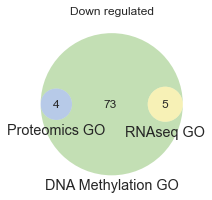

In [20]:

test_title = 'Stage_IV_vs_Stage_I'
p_cutoff = 0.25
files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Down regulated': ['RNAseq_GSEA_MetabolicPathways.csv',
                                  'Protein_GSEA_MetabolicPathways.csv',
                                  'Methylation_GSEA_MetabolicPathways.csv'
                                 ]
              }
for c in comparisons:
    combined_df = pd.DataFrame()
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    
        # Combine the DFs to save for mor easy viewing
    rna_df['Data'] = ['RNA']*len(rna_df)
    protein_df['Data'] = ['Protein']*len(protein_df)
    cpg_df['Data'] = ['CpG']*len(cpg_df)
    
    combined_df = combined_df.append(rna_df)
    combined_df = combined_df.append(protein_df)
    combined_df = combined_df.append(cpg_df)
    combined_df.to_csv(f'../data/sircle/F8_simple_integration/{c}_GSEA-metabolic_StageIV-StageI-Tumour.csv', index=False)
    # Look at significant terms
    rna_df = rna_df[rna_df['padj'] < p_cutoff]
    rna_df = rna_df[rna_df['NES'] < 0]
    protein_df = protein_df[protein_df['padj'] < p_cutoff]
    protein_df = protein_df[protein_df['NES'] < 0]
    cpg_df = cpg_df[cpg_df['padj'] < p_cutoff]
    cpg_df = cpg_df[cpg_df['NES'] > 0]
    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    print(set(rna_df.pathway.values) & set(protein_df.pathway.values))
    print(set(cpg_df.pathway.values) & set(protein_df.pathway.values))
    print(set(rna_df.pathway.values) & set(cpg_df.pathway.values))
    
    venn3([set(protein_df.pathway.values), set(rna_df.pathway.values), set(cpg_df.pathway.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    #plt.savefig(f'{output_dir}Venn_pathway_{test_title}_{c}.svg')

    plt.title(c)
    plt.show()


--------------------------------------------------------------------------------
                      RNA sig:	25	Protein sig:	18	CpG:	0	                       
--------------------------------------------------------------------------------
{'N-Glycan Biosynthesis', 'Chondroitin sulfate degradation', 'N-Glycan Degradation', 'Keratan sulfate degradation', 'Arginine and Proline Metabolism', 'Protein Modification', 'Fatty Acid Biosynthesis', 'Transport, Lysosomal'}
set()
set()


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3800545093.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(rna_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3800545093.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(protein_df)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_20776/3800545093.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(cpg_df)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


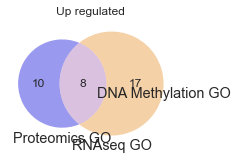

In [22]:

test_title = 'Stage_IV_vs_Stage_I'

files = os.listdir(data_dir)
cluster_files = [c for c in files if test_title in c and 'Positive' in c and 'csv' in c]
comparisons = {'Up regulated': ['RNAseq_GSEA_MetabolicPathways.csv',
                                  'Protein_GSEA_MetabolicPathways.csv',
                                  'Methylation_GSEA_MetabolicPathways.csv'
                                 ]
              }
for c in comparisons:
    rna_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][0]}')
    protein_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][1]}')
    cpg_df = pd.read_csv(f'{data_dir}{test_title}_{comparisons[c][2]}')
    # Look at significant terms
    combined_df = pd.DataFrame()
    rna_df['Data'] = ['RNA']*len(rna_df)
    protein_df['Data'] = ['Protein']*len(protein_df)
    cpg_df['Data'] = ['CpG']*len(cpg_df)
    combined_df = combined_df.append(rna_df)
    combined_df = combined_df.append(protein_df)
    combined_df = combined_df.append(cpg_df)
    combined_df.to_csv(f'../data/sircle/F8_simple_integration/{c}_GSEA-metabolic_StageIV-StageI-Tumour.csv', index=False)
    
    rna_df = rna_df[rna_df['padj'] < p_cutoff]
    rna_df = rna_df[rna_df['NES'] > 0]
    protein_df = protein_df[protein_df['padj'] < p_cutoff]
    protein_df = protein_df[protein_df['NES'] > 0]
    cpg_df = cpg_df[cpg_df['padj'] < p_cutoff]
    cpg_df = cpg_df[cpg_df['NES'] < 0]
    u.dp(['RNA sig:', len(rna_df), 'Protein sig:', len(protein_df), 'CpG:', len(cpg_df)])
    print(set(rna_df.pathway.values) & set(protein_df.pathway.values))
    print(set(cpg_df.pathway.values) & set(protein_df.pathway.values))
    print(set(rna_df.pathway.values) & set(cpg_df.pathway.values))

    venn3([set(protein_df.pathway.values), set(rna_df.pathway.values), set(cpg_df.pathway.values)], set_labels=['Proteomics GO', 'RNAseq GO',
                                                                      'DNA Methylation GO'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
    plt.rcParams['svg.fonttype'] = 'none'
    #plt.savefig(f'{output_dir}Venn_pathway_{test_title}_{c}.svg')

    plt.title(c)
    plt.show()
